# OpenPack Dataset - Data Visualization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-pack/openpack-toolkit/blob/main/samples/OpenPack_DataVisualization.ipynb)

This notebook shows how to download and visualize the OpenPack dataset data and file formats.
We are developping a python package named [`openpack-tooklit` (link)](https://github.com/open-pack/openpack-toolkit) to accelerate the usability of this dataset.
Through this tutorial, we hope to help you get an overview of the dataset and get familiar with our data and tools.

## Table of Contents
1. Download the OpenPack Dataset
1. Visualize the OpenPack Dataset
    1. Annotation Data (`openpack-operatsion`)
    1. IMU Data (`atr-qags`)
    1. Keypoints (`kinect-2d-kpt`)


## Note 
In this tutorial we to use `./data/datasets` as a dataset directory. Please change this path to fit your envirinment.

## [1] Donwload OpenPack Dataset

OpenPack dataset can be downloaded from [zenodo](https://doi.org/10.5281/zenodo.5909086), an online repository for Open Science.
OpenPack data is split into several subdirectories (by subject and by sensor stream) and individual zipped files are available in zenodo. You can choose to download, unzip and integrate them one by one. 
Here, we will show an easier way to download and setup the files directly using the `openpack-toolkit (optk)`.
The first step is to install `openpack-tooklit` via pip and download the dataset. 

### 1-1: Install `openpack-tooklit (optk)` from PyPI

In the command line run

In [ ]:
! pip install openpack-toolkit

After installation, import the toolkit and verify the package version.

In [1]:
import openpack_toolkit as optk
print("version", optk.__version__)

version 0.6.0


### 1-2: Download OpenPack Dataset

If you are running this notebook in colab, please mount your Google Drive to reduce the workload on the zenodo server.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

`optk-download` is a shell command installed along with `openpack-tooklit`. 
3 parameters are required to use this command.

- `-d` (dataset dir): a directory to store the OpenPack dataset. In this tutorial, we use `/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets`. This directory will not be created automatically. Please make sure whether this directory exists in advance.
- `-v` (version): a dataset version indicator. Here we use `v0.2.0` (latest version at 2022-07-05).
- `-s` (streams): a list of data stream specifiers. Please list up your desired data stream keys from the ones listed [here (sensor data)](https://github.com/open-pack/openpack-toolkit/blob/main/docs/DATA_STREAM.md) and [here (annotations)](https://github.com/open-pack/openpack-toolkit/blob/main/docs/ANNOTATION.md) with comma separated format.

In [1]:
# Usage of `optk-download` command
! optk-download -h

usage: optk-download [-h] -d DATASET_DIR [-v VERSION] [-s STREAMS]

optional arguments:
  -h, --help            show this help message and exit
  -d DATASET_DIR, --dataset-dir DATASET_DIR
                        Path to dataset directory. Downloaded data will be
                        stored under the directory.
  -v VERSION, --version VERSION
                        Target dataset version. Default: v0.3.0
  -s STREAMS, --streams STREAMS
                        A list of data stream names that you want to download.
                        Stream names must be separated by commas. If none, all
                        data in zenodo will be downloaded.Defaul: none


In [10]:
# make dataset directory
! mkdir -p "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"

In [2]:
DATASET_ROOTDIR = "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"
OPENPACK_VERSION = "v0.3.0"

In [3]:
# This takes few minute.
! optk-download -d "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets" -v $OPENPACK_VERSION

INFO:openpack_toolkit.bin.download:Donwload OpenPack dataset from zenodo.
INFO:openpack_toolkit.bin.download: - dataset_dir : /content/drive/MyDrive/Colab Notebooks/openpack/data/datasets
INFO:openpack_toolkit.bin.download: - version     : v0.3.0
INFO:openpack_toolkit.bin.download: - streams     : ['activity-1s', 'atr-qags', 'kinect-2d-kpt', 'system-order-sheet', 'system-ht-original', 'system-printer', 'e4-acc', 'e4-bvp', 'e4-eda', 'e4-temp']
INFO:openpack_toolkit.download._helpers:== [0/10] activity-1s ==
INFO:openpack_toolkit.download._helpers:[0/17] U0101
INFO:openpack_toolkit.download._helpers:[1/17] U0102
INFO:openpack_toolkit.download._helpers:[2/17] U0103
INFO:openpack_toolkit.download._helpers:[3/17] U0104
INFO:openpack_toolkit.download._helpers:[4/17] U0105
INFO:openpack_toolkit.download._helpers:[5/17] U0106
INFO:openpack_toolkit.download._helpers:[6/17] U0107
INFO:openpack_toolkit.download._helpers:[7/17] U0108
INFO:openpack_toolkit.download._helpers:[8/17] U0109
INFO:openpa

When the dataset download is finished, the dataset directory should look like this. (note: subdirectories might look different depending on selected data streams)

In [ ]:
! apt update & apt install tree -y
! tree "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack"

## [2] Load and Visualize Data in OpenPack Dataset

In OpenPack dataset, all configurations including file locations are managed by [`omegaconf` (link)](https://omegaconf.readthedocs.io/en/latest/), a YAML-based hierarchical configuration system. 
`openpack-toolkit` provides python's data class instances (defined [here](https://github.com/open-pack/openpack-toolkit/tree/main/openpack_toolkit/configs)) and can be used to get the file location.


Config YAML files are stored [here](https://github.com/open-pack/openpack-toolkit/tree/main/configs).
Detailed information can be obtained by reading these config files.


To get the desired variable using the config object `openpack-toolkit` utilizes OmegaConf's variable interpolation feature.
We recommend reading [this document (official docs of omegaconf)](https://omegaconf.readthedocs.io/en/latest/usage.html#variable-interpolation) to deepen your understanding.

First step is importing required libraries

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import json
import openpack_toolkit as optk
from omegaconf import DictConfig, OmegaConf, open_dict
from openpack_toolkit.utils.notebook import noglobal

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns
sns.set("notebook", "whitegrid", font_scale=1.5)

The root config object is defined like this.

In [5]:
cfg = OmegaConf.create({
    "user": optk.configs.users.U0102,
    "session": None,
    "path": {
        "openpack": {
            "version": OPENPACK_VERSION,
            "rootdir": DATASET_ROOTDIR + "/openpack/${.version}",
        },
    },
    "dataset": {
        "annotation": None,
        "stream": None,
    }
})

In [6]:
print(OmegaConf.to_yaml(cfg))

user:
  id: 102
  name: U0102
  sessions:
    S0100:
      duration: 50m13s
      end: '2021-10-22T12:10:07+09:00'
      start: '2021-10-22T11:19:54+09:00'
    S0200:
      duration: 39m08s
      end: '2021-10-22T13:10:22+09:00'
      start: '2021-10-22T12:31:14+09:00'
    S0300:
      duration: 36m44s
      end: '2021-10-22T14:51:28+09:00'
      start: '2021-10-22T14:14:44+09:00'
    S0400:
      duration: 33m18s
      end: '2021-10-22T15:41:36+09:00'
      start: '2021-10-22T15:08:18+09:00'
    S0500:
      duration: 30m22s
      end: '2021-10-22T16:26:48+09:00'
      start: '2021-10-22T15:56:26+09:00'
session: null
path:
  openpack:
    version: v0.3.0
    rootdir: /content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/${.version}
dataset:
  annotation: null
  stream: null



## 2-A: Annotation Data (openpack-operations)

- [docs](https://github.com/open-pack/openpack-toolkit/blob/main/docs/ANNOTATION.md#1-openpack_operations)
- [config](https://github.com/open-pack/openpack-toolkit/blob/main/configs/dataset/annotation/openpack-operations.yaml)

The definitions for activity classes and file formats are described [here](https://github.com/open-pack/openpack-toolkit/blob/main/docs/ANNOTATION.md).
In this section, we explore the activity set named `OPENPACK_OPERATIONS` (key = `openpack-operations`).
This activity set consists of 10 work operations and its data is saved in CSV format. 
In the OpenPack challenge, a task for participants is to localize these activities.

In [7]:
print(OmegaConf.to_yaml(optk.OPENPACK_OPERATIONS))

classes:
- id: 100
  name: Picking
  is_ignore: false
- id: 200
  name: Relocate Item Label
  is_ignore: false
- id: 300
  name: Assemble Box
  is_ignore: false
- id: 400
  name: Insert Items
  is_ignore: false
- id: 500
  name: Close Box
  is_ignore: false
- id: 600
  name: Attach Box Label
  is_ignore: false
- id: 700
  name: Scan Label
  is_ignore: false
- id: 800
  name: Attach Shipping Label
  is_ignore: false
- id: 900
  name: Put on Back Table
  is_ignore: false
- id: 1000
  name: Fill out Order
  is_ignore: false
- id: 8100
  name: 'Null'
  is_ignore: true



First, we get the path to the annotation data of U0102-S0100 using omegconf.
The path to the annotation data is defined in `optk.configs.dataset.annotations.ACTIVITY_1S_ANNOTATION.path`.
`ACTIVITY_1S_ANNOTATION` contains metadata of the annotation file. This files contains the operation and actions labels sampled at 1 Hz.

As it can be seen, values in the config contain placeholders and they will be interpolated when you access these attributes.
So you need to set the required variables (`session`, etc) first and access the config to get the desired path.

In [8]:
# NOTE: Path template is defined in `path` attribute.
print("conf_type:", optk.configs.datasets.annotations.ACTIVITY_1S_ANNOTATION.conf_type)
print("name:", optk.configs.datasets.annotations.ACTIVITY_1S_ANNOTATION.name)
print(OmegaConf.to_yaml(optk.configs.datasets.annotations.ACTIVITY_1S_ANNOTATION.path))

conf_type: ANNOT_FILE
name: activity-1s
dir: ${path.openpack.rootdir}/${user.name}/annotation/activity-1s/
fname: ${session}.csv



In [9]:
# Set parameters to the config object.
# NOTE: user.name is already defined above. See [2]
cfg.dataset.annotation = optk.configs.datasets.annotations.ACTIVITY_1S_ANNOTATION
cfg.session = "S0100"

path = Path(
    cfg.dataset.annotation.path.dir, 
    cfg.dataset.annotation.path.fname,     
)
print(path)

/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0102/annotation/activity-1s/S0100.csv


In [10]:
# Load CSV file
df = pd.read_csv(path)

In [11]:
df

,unixtime,user,session,box,operation,action
0,1634869195000,U0102,S0100,1,100,101
1,1634869196000,U0102,S0100,1,100,101
2,1634869197000,U0102,S0100,1,100,8100
3,1634869198000,U0102,S0100,1,100,8100
4,1634869199000,U0102,S0100,1,100,108
...,...,...,...,...,...,...
3004,1634872199000,U0102,S0100,20,1000,1001
3005,1634872200000,U0102,S0100,20,1000,1002
3006,1634872201000,U0102,S0100,20,1000,1002
3007,1634872202000,U0102,S0100,20,1000,1002


The imported DataFrame contains unixtime, operation class IDs and so on.
`unixtime` is important in the OpenPack dataset. When using multiple data streams, it is possible to use the `unixtime` to align the sequences.

Next, we visualize loaded annotation data.

In [12]:
@noglobal()
def plot_openpack_operations(df: pd.DataFrame, xlim=None, figsize=(30, 7), OPENPACK_OPERATIONS=optk.OPENPACK_OPERATIONS):
    seq_len = len(df)
    
    df["cls_idx"] = optk.OPENPACK_OPERATIONS.convert_id_to_index(df["operation"])

    df_head = df.drop_duplicates(["user", "session", "box"], keep="first")
    df_tail = df.drop_duplicates(["user", "session", "box"], keep="last")
    df_box = pd.DataFrame({
        "box": df_head["box"],
        "start": df_head.index,
        "end": df_tail.index,
    }).reset_index(drop=True)

    # == Plot ==
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    xloc = np.arange(seq_len)

    ax0.plot(xloc, df["cls_idx"], lw=3)
    for index, row in df_box.iterrows():
        ax0.fill_between([row.start, row.end], 0, 11, color=f"C{row.box%10}", alpha=0.2)
        ax0.text(
            row.start, 11, f"Box{row.box:0=2}",
            fontweight="bold", color="black",
        )

    xticks = np.arange(0, seq_len, 60 * 2)
    xticks_minor = np.arange(0, seq_len, 30)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 60)
    ax0.set_xticks(xticks_minor, minor=True)
    ax0.set_xlabel("Time [min]", fontweight="bold")
    if xlim is None:
        ax0.set_xlim([0, seq_len])
    else:
        ax0.set_xlim(xlim)

    yticklabels = [k for k in OPENPACK_OPERATIONS.get_ids()]
    ax0.set_yticks(np.arange(len(OPENPACK_OPERATIONS)))
    ax0.set_yticklabels(yticklabels)
    ax0.set_ylabel("Class ID")

    ax0.grid(True, which="minor", linestyle=":")

    ax0.set_title(f"OPENPACK OPERATIONS", fontsize="x-large", fontweight="bold")

    fig.tight_layout()
    return fig

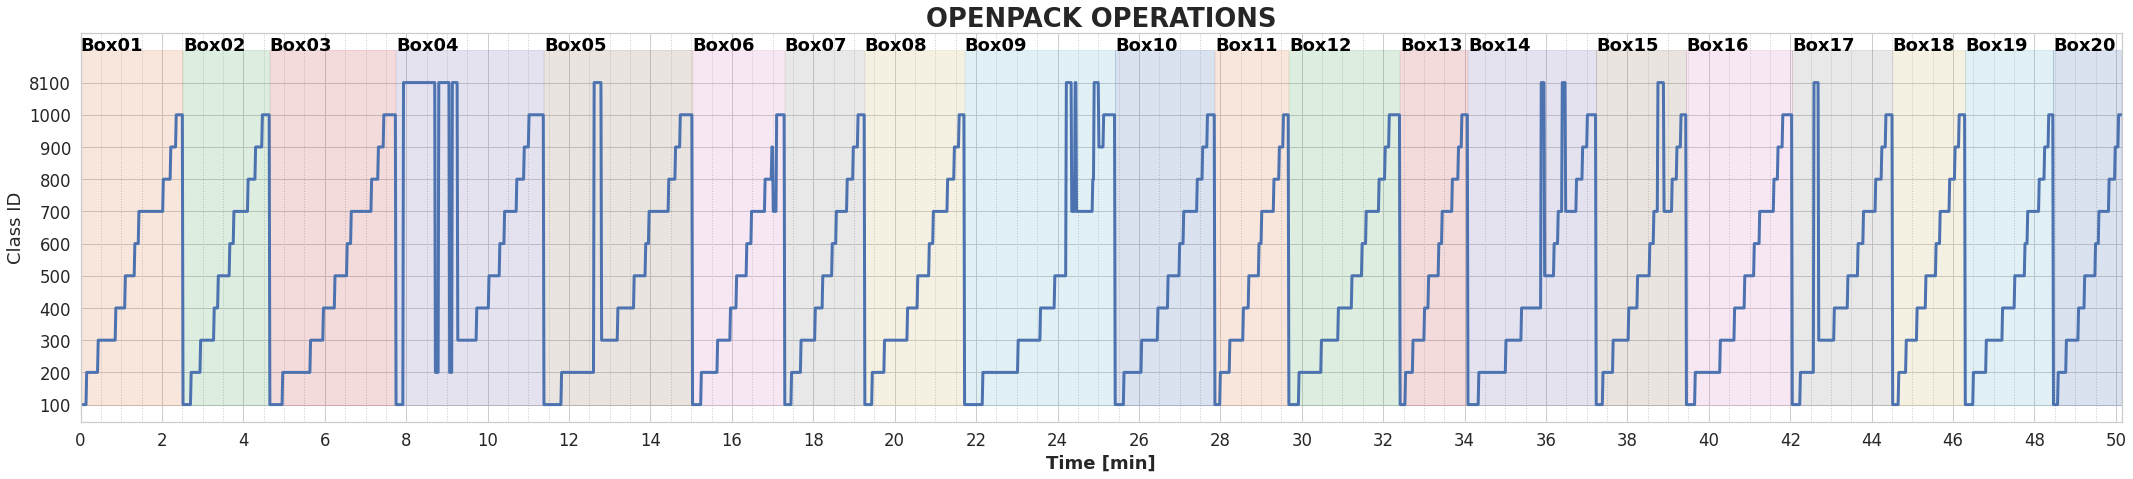

In [13]:
fig = plot_openpack_operations(df)
fig.show()

### Tips: Resample Label Sequence

The sampling rate of operation labels is 1 Hz, but sensor data streams have different sampling rates.
It is posible to get any label sequence in the desired sampling interval with [`optk.data.load_and_resample_operation_labels()` (API Docs)](https://open-pack.github.io/openpack-toolkit/openpack_toolkit/data/index.html#openpack_toolkit.data.load_and_resample_operation_labels). This function returns activity IDs and indexes at the given timestamps (unixtime). 


In [14]:
""" Examples from https://github.com/open-pack/openpack-toolkit/blob/f12cd1e9b1c497d7f10558bf8149a04cd71cc781/tests/data/test_dataloader.py
"""
cfg.session = "S0500"
path = Path(
    cfg.dataset.annotation.path.dir,
    cfg.dataset.annotation.path.fname,
)
print(f"input path: {path} (exists={path.exists()})")

unixtimes = np.array([
    1634885794000,
    1634885794200,  # Resampling 1
    1634885794400,  # Resampling 2
    1634885794600,  # Resampling 3
    1634885794800,  # Resampling 4
    1634885795000,
    1634885796000,
    1634885798000,  # Next Action
])


df_annot = optk.data.load_and_resample_operation_labels(path, unixtimes, classes=optk.OPENPACK_OPERATIONS)

input path: /content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0102/annotation/activity-1s/S0500.csv (exists=True)


In [15]:
df_annot

,unixtime,annot_time,user,session,box,act_id,act_idx
0,1634885794000,1634885794000,U0102,S0500,1,100,0
1,1634885794200,1634885794000,U0102,S0500,1,100,0
2,1634885794400,1634885794000,U0102,S0500,1,100,0
3,1634885794600,1634885794000,U0102,S0500,1,100,0
4,1634885794800,1634885794000,U0102,S0500,1,100,0
5,1634885795000,1634885795000,U0102,S0500,1,100,0
6,1634885796000,1634885796000,U0102,S0500,1,200,1
7,1634885798000,1634885798000,U0102,S0500,1,200,1


## 2-B: Acceratation, Gyroscope, and Quaterinon from IMU (`atr-qags`)

- [Docs](https://github.com/open-pack/openpack-toolkit/blob/main/docs/DATA_STREAM.md#1-atr-qags)

Subjects wore 4 IMU sensors ([ATR-TSND151](http://www.atr-p.com/products/TSND121_151.html)). 
These sensors recorded acceratation, gyroscope, and quaterinon sequences. These data can be used to predict work operations in the challenge.
The data is saved as CSV file.

Let's load and visualize data from atr01 (IMU sensor attached to the right wrist). The procedure is almost the same as that for annotation described above. (note how we changed the conf key from 'datasets.annotations.OPENPACK_OPERATIONS_ANNOTATION' to 'datasets.streams.ATR_QAGS_STREAM')

In [16]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.ATR_QAGS_STREAM))

schema: ImuConfig
name: atr-qags
description: null
super_stream: None
path:
  dir: ${path.openpack.rootdir}/${user.name}/atr/${device}
  fname: ${session}.csv
file_format: null
frame_rate: 30
devices:
- atr01
- atr02
- atr03
- atr04
acc: true
gyro: true
quat: true



In [17]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.ATR_QAGS_STREAM
cfg.session = "S0100"
cfg.device = "atr01"

path = Path(
    cfg.dataset.stream.path.dir, 
    cfg.dataset.stream.path.fname,     
)
print(path)

/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0102/atr/atr01/S0100.csv


In [18]:
# Load CSV file
df = pd.read_csv(path)

In [19]:
df

,unixtime,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,quat_w,quat_x,quat_y,quat_z
0,1634869193027,0.0548,0.9462,0.3235,1.19,3.22,3.29,0.0,0.0,0.0,0.0
1,1634869193060,0.0689,0.9371,0.3079,1.50,-17.96,3.71,0.0,0.0,0.0,0.0
2,1634869193093,0.1195,0.9435,0.2842,2.32,-24.72,5.70,0.0,0.0,0.0,0.0
3,1634869193126,0.1561,0.9445,0.2835,2.52,-25.43,7.42,0.0,0.0,0.0,0.0
4,1634869193159,0.1803,0.9330,0.2769,2.87,-18.66,7.82,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
91358,1634872207841,0.8516,0.5868,0.4795,79.27,60.17,-10.52,0.0,0.0,0.0,0.0
91359,1634872207874,0.7725,0.5795,0.3990,63.07,65.45,-3.70,0.0,0.0,0.0,0.0
91360,1634872207907,0.7454,0.6195,0.4908,42.26,60.21,5.59,0.0,0.0,0.0,0.0
91361,1634872207940,0.7005,0.5997,0.4773,15.93,51.97,6.06,0.0,0.0,0.0,0.0


Next, we visualize loaded sensor stream data.

In [20]:
@noglobal()
def plot_atr_qags(df: pd.DataFrame, cfg: DictConfig):
    seq_len = len(df)
    
    
    fig = plt.figure(figsize=(30, 2.5 * 4))
    gs_master = GridSpec(nrows=2, ncols=1, height_ratios=[3, 1])
    gs_line = GridSpecFromSubplotSpec(
        nrows=3, ncols=1, subplot_spec=gs_master[0], hspace=0.05)
    gs_hist = GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=gs_master[1])

    data = [
        {
            "label": "Acc [G]",
            "cols": ["acc_x", "acc_y", "acc_z"],
            "lim": [-4.0, 4.0],
        },
        {
            "label": "Gyro [dps]",
            "cols": ["gyro_x", "gyro_y", "gyro_z"],
            "lim": [-500.0, 500.0],
        },
        {
            "label": "Quaternion",
            "cols": ["quat_w", "quat_x", "quat_y", "quat_z"],
            "lim": [-1.5, 1.5],
        },
    ]
    xloc = df.index.values
    for i, d in enumerate(data):
        cols = d["cols"]
        ylabel = d["label"]
        lim = d["lim"]

        X = df[cols].values.T

        # -- Sequence (Acc / Gyro / Quat) --
        ax0 = fig.add_subplot(gs_line[i])
        for ch, col_name in enumerate(cols):
            ax0.plot(xloc, X[ch], label=col_name, color=f"C{ch}", alpha=0.75)

        xticks = np.arange(0, seq_len + 1, 30 * 60 * 2)
        xticks_minor = np.arange(0, seq_len + 1, 30 * 30)
        ax0.set_xticks(xticks)
        ax0.set_xticklabels(xticks // (30 * 60))
        ax0.set_xticks(xticks_minor, minor=True)
        ax0.set_xlim([0, seq_len])

        ax0.set_ylabel(ylabel, fontweight="bold")

        ax0.grid(True, which="minor", linestyle=":")
        ax0.legend(loc="upper right")

        if i == 2:
            ax0.set_xlabel("Time [min]", fontweight="bold")
        else:
            ax0.tick_params(
                labelbottom=False
            )

        # -- Histgram --
        ax1 = fig.add_subplot(gs_hist[i])
        for ch, col_name in enumerate(cols):
            ax1.hist(
                X[ch],
                range=lim,
                bins=50,
                label=col_name,
                color=f"C{ch}",
                alpha=0.50)

        ax1.set_xlabel(ylabel, fontweight="bold")
        ax1.set_ylabel("Freq", fontweight="bold")
        ax1.legend(loc="upper right")

    fig.suptitle(
        f"IMU - {cfg.device} | {cfg.user.name}-{cfg.session}",
        fontsize="x-large",
        fontweight="black")
    fig.tight_layout()
    return fig


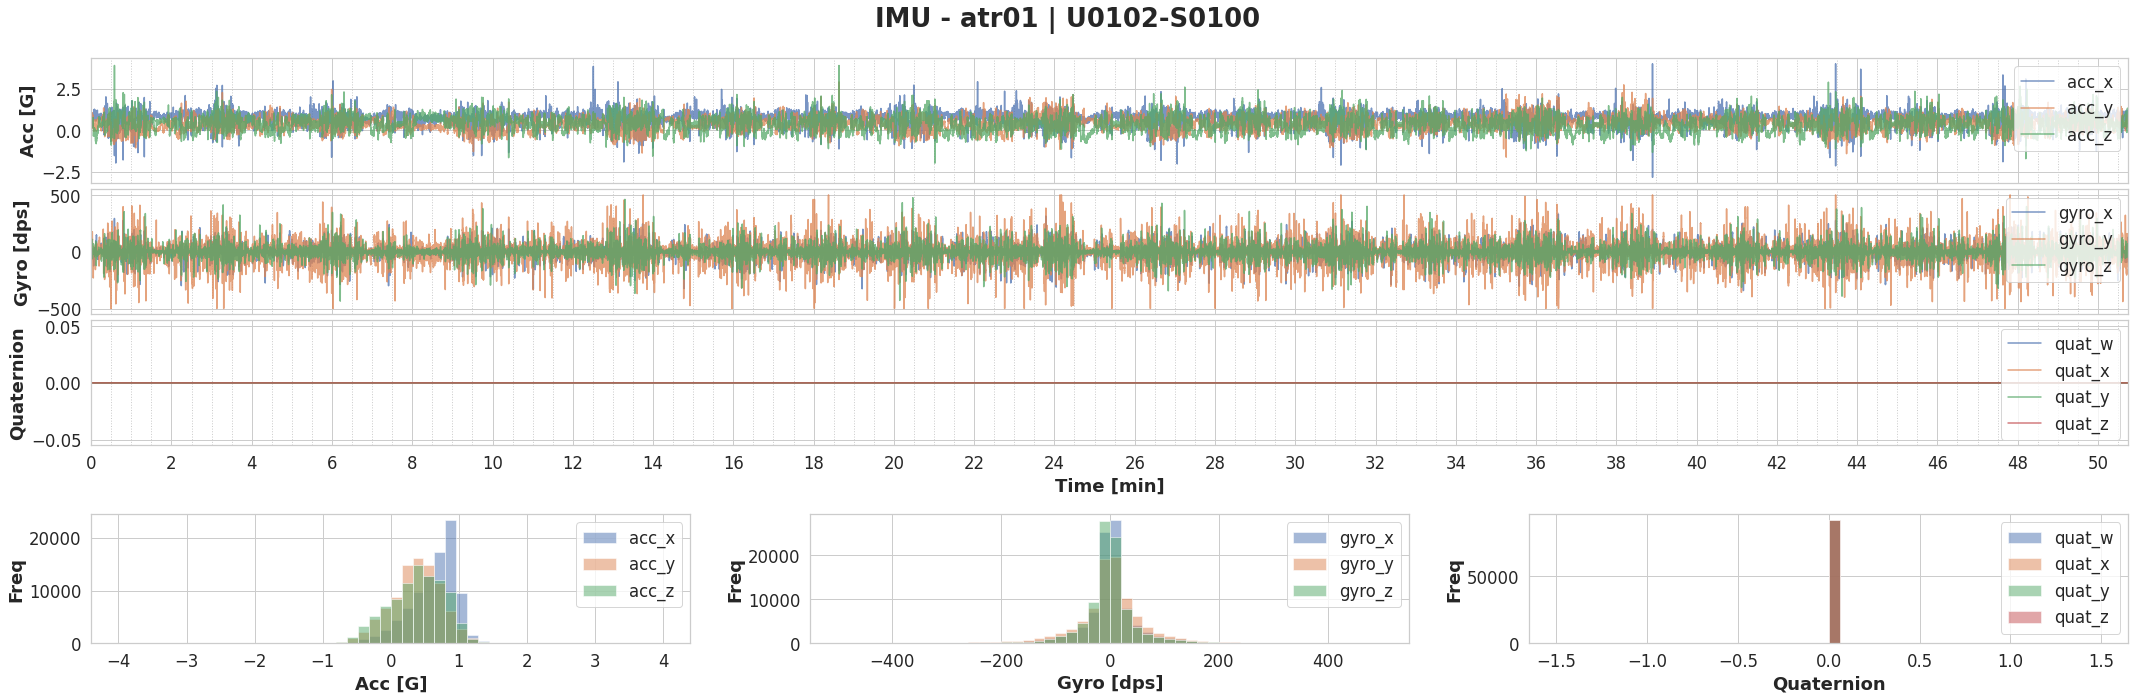

In [21]:
fig = plot_atr_qags(df, cfg)
fig.show()

**NOTE: Quaterion data is missing for some subjects. Please check user details before using them.**

### Tips: Load multiple IMU sequences at Once

Use `optk.data.load_imu()` to load IMU data from multiple devices, e.g., left and right wrist.
This function retuns sequences after time alignment.

In [22]:
# Make path list
paths = []
devices = ["atr01", "atr02"]

for device in devices:
    cfg.device = device
    paths.append(
        Path(
            cfg.dataset.stream.path.dir,
            cfg.dataset.stream.path.fname,
        )
    )

display(paths)

[PosixPath('/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0102/atr/atr01/S0100.csv'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0102/atr/atr02/S0100.csv')]

In [23]:
# Get only ACC data.
T, X = optk.data.load_imu(paths, use_acc=True, use_gyro=False, use_quat=False)
print(f"X={X.shape}, T={T.shape}")

X=(6, 91363), T=(91363,)


X's first dim = `["acc_x@atr01", "acc_y @atr01", "acc_x@atr01", "acc_x@atr02", "acc_y @atr02", "acc_x@atr02"] `

## 2-C: Keypoints (`kinect-2d-kpt`)

- [Docs](https://github.com/open-pack/openpack-toolkit/blob/main/docs/DATA_STREAM.md#2-kinect-2d-kpt)

2D keypoints are extracted from kinect recordings (front-view) using [open-mmlab/mmpose](https://github.com/open-mmlab/mmpose).
Keypoints data is provided in a MS COCO JSON file.

In [24]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.KINECT_2D_KPT_STREAM))

schema: KeypointConfig
name: kinect-2d-kpt
description: null
super_stream: None
path:
  dir: ${path.openpack.rootdir}/${user.name}/kinect/${..category}/${..model}/single
  fname: ${session}.json
file_format: null
frame_rate: 15
category: 2d-kpt
model: mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2
nodes:
  0: nose
  1: left_eye
  2: right_eye
  3: left_ear
  4: right_ear
  5: left_shoulder
  6: right_shoulder
  7: left_elbow
  8: right_elbow
  9: left_wrist
  10: right_wrist
  11: left_hip
  12: right_hip
  13: left_knee
  14: right_knee
  15: left_ankle
  16: right_ankle



In [25]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.KINECT_2D_KPT_STREAM
cfg.session = "S0100"

path = Path(
    cfg.dataset.stream.path.dir, 
    cfg.dataset.stream.path.fname,     
)
print(path)

/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0102/kinect/2d-kpt/mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2/single/S0100.json


In [26]:
# Load JSON file
with open(path, "r") as f:
    data = json.load(f)

In [27]:
data.keys()

dict_keys(['info', 'licenses', 'annotations', 'categories'])

In [28]:
data["info"]

{'year': 2022,
 'version': 'v0.2.0',
 'description': 'openpack/U0102/2d-kpt/mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2/single/S0100',
 'contributor': 'Naoya Yoshimura, Jaime Morales, Takuya Maekawa',
 'url': 'https://open-pack.github.io',
 'date_created': '2022/03/31'}

In [29]:
data["licenses"]

[{'id': 0,
  'name': 'Creative Commons Attribution Non Commercial Share Alike 4.0 International',
  'url': 'https://open-pack.github.io'}]

In [30]:
data["categories"]

[{'supercategory': 'person',
  'id': 1,
  'name': 'person',
  'keypoints': ['nose',
   'left_eye',
   'right_eye',
   'left_ear',
   'right_ear',
   'left_shoulder',
   'right_shoulder',
   'left_elbow',
   'right_elbow',
   'left_wrist',
   'right_wrist',
   'left_hip',
   'right_hip',
   'left_knee',
   'right_knee',
   'left_ankle',
   'right_ankle'],
  'skeleton': [[16, 14],
   [14, 12],
   [17, 15],
   [15, 13],
   [12, 13],
   [6, 12],
   [7, 13],
   [6, 7],
   [6, 8],
   [7, 9],
   [8, 10],
   [9, 11],
   [2, 3],
   [1, 2],
   [1, 3],
   [2, 4],
   [3, 5],
   [4, 6],
   [5, 7]]}]

In [31]:
data["annotations"][0]

{'id': 1634869192038000,
 'image_id': 1634869192038,
 'category_id': 1,
 'area': 56387.824,
 'bbox': [597.3, 320.4, 174.6, 322.9],
 'iscrowd': 0,
 'keypoints': [[698.8, 373.7, 0.92614394],
  [688.2, 407.5, 0.83524674],
  [690.3, 350.5, 0.8222388],
  [717.8, 380.0, 0.29044425],
  [658.7, 363.2, 0.42727488],
  [738.8, 426.4, 0.86197984],
  [635.5, 424.3, 0.85390973],
  [753.6, 521.3, 0.7679441],
  [618.6, 506.6, 0.8285348],
  [757.8, 597.3, 0.88464993],
  [610.2, 586.7, 0.8356974],
  [711.4, 586.7, 0.6472243],
  [641.8, 582.5, 0.6692864],
  [696.7, 673.2, 0.43312368],
  [641.8, 664.7, 0.42528123],
  [724.1, 628.9, 0.16155383],
  [622.9, 626.8, 0.10479919]],
 'num_keypoints': 17,
 'bbox_score': 0.9971596,
 'track_id': 106}

At last, let's visualize some keypoints sequence.

In [32]:
@noglobal()
def plot_kinect_2d_kpt(annots: dict, cfg: DictConfig):
    FS = 15
    seq_len = len(annots)

    # == Plot ==
    sns.set("notebook", "whitegrid")
    fig = plt.figure(figsize=(30, 2.5 * 3))
    gs_master = GridSpec(nrows=3, ncols=1)

    # -- Keypoints Location --
    data = [
        {
            "node": "nose",
            "idx": 0,
        },
        {
            "node": "Left Shoulder",
            "idx": 5,
        },
    ]
    xloc = np.arange(len(annots))
    for i, d in enumerate(data):
        title = d["node"]
        kpt_idx = d["idx"]

        X = np.array([annots[i]["keypoints"] for i in range(len(annots))])

        # -- Sequence (Acc / Gyro / Quat) --
        ax0 = fig.add_subplot(gs_master[i])
        ax1 = ax0.twinx()

        # prediction score
        ax1.fill_between(xloc, X[:, kpt_idx, 2], label="Score", color="C0", alpha=0.1)
        # Plot position
        for ch in range(2):
            ax0.plot(
                xloc,
                X[:, kpt_idx, ch],
                label="X-axis" if ch == 0 else "Y-axis",
                color=f"C{ch}",
                alpha=0.75,
            )

        xticks = np.arange(0, seq_len + 1, FS * 60 * 2)
        xticks_minor = np.arange(0, seq_len + 1, FS * 30)
        ax0.set_xticks(xticks)
        ax0.set_xticklabels(xticks // (FS * 60))
        ax0.set_xticks(xticks_minor, minor=True)
        ax0.set_xlim([0, seq_len])
        ax0.set_ylabel("Position [px]", fontweight="bold")

        ax1.set_yticks(np.arange(0, 1.1, 0.2))
        ax1.set_ylabel("Score", fontweight="bold")

        ax0.grid(True, which="minor", linestyle=":")
        ax0.legend(loc="upper left")
        ax1.legend(loc="upper right")
        ax0.set_title(f"{title} [IDX={kpt_idx}]", fontweight="bold", fontsize="x-large")

        if i == 1:
            ax0.set_xlabel("Time [min]", fontweight="bold")
        else:
            ax0.tick_params(
                labelbottom=False
            )

    # -- [2] Tracking Id --
    ax0 = fig.add_subplot(gs_master[2])
    X = np.array([annots[i]["track_id"] for i in range(len(annots))])
    ax0.scatter(xloc, X, color="C0", alpha=0.75, s=5)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // (FS * 60))
    ax0.set_xticks(xticks_minor, minor=True)
    ax0.set_xlim([0, seq_len])
    ax0.set_ylabel("Track ID", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")

    fig.suptitle(
        f"Kinect 2d-kpt | {cfg.user.name}-{cfg.session}",
        fontsize="x-large",
        fontweight="black")
    fig.tight_layout()
    return fig, 

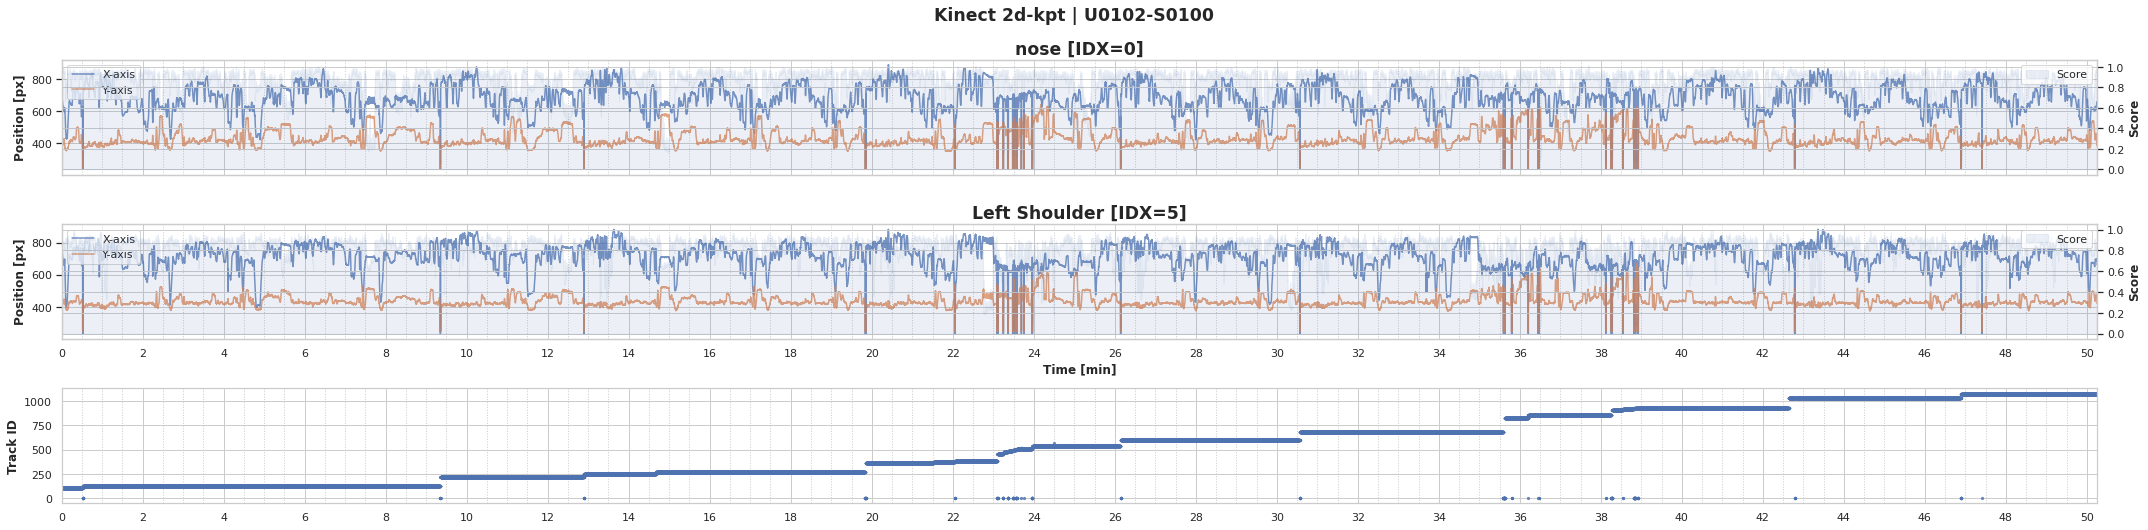

In [33]:
fig = plot_kinect_2d_kpt(data["annotations"], cfg)

### Tips: Directly Load Keypoints Sequence

The imported JSON file (MS COCO format) contains a lot of information but not everything is necessary for activity recognition.
You can use `optk.load_kyepoints()` to only get the keypoints sequence.
Skeleton with MS COCO format contains coordinates of 17 joints. Therefore the shape of X is `(X/Y/Score, Time, JOINT)`.

In [34]:
path = Path(
    cfg.dataset.stream.path.dir,
    cfg.dataset.stream.path.fname,
)
print(path)

T, X = optk.data.load_keypoints(path)
print(f"Timetamp [unixtime]: T={T.shape}")
print(f"Keypoints          : X={X.shape}")

/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0102/kinect/2d-kpt/mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2/single/S0100.json
Timetamp [unixtime]: T=(45235,)
Keypoints          : X=(3, 45235, 17)


## 2-D: Data from E4 (Acceratation, BVP, EDA, and Temperature; `e4-XXX`)

- [Docs](https://github.com/open-pack/openpack-toolkit/blob/main/docs/DATA_STREAM.md#3-e4-acc)

Subjects wore 2 [Empatica E4](https://www.empatica.com/en-int/research/e4/) sensors. 
These sensors recorded acceratation, BVP (Blood Volume Pulse), EDA, and temperature sequences. These data can be used to predict work operations in the challenge.
The data is saved as CSV file.

Let's load and visualize data from e401 (E4 sensor attached to the right wrist).

### E4 - Acc

In [35]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.E4_ACC_STREAM))

schema: ImuConfig
name: e4-acc
description: null
super_stream: null
path:
  dir: ${path.openpack.rootdir}/${user.name}/e4/${device}/acc
  fname: ${session}.csv
file_format: null
frame_rate: 32
devices:
- e401
- e402
sensor: ''



In [36]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.E4_ACC_STREAM
cfg.user = optk.configs.users.U0101
cfg.session = "S0100"
cfg.device = "e401"

path = Path(
    cfg.dataset.stream.path.dir, 
    cfg.dataset.stream.path.fname,     
)
print(path)

/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0101/e4/e401/acc/S0100.csv


In [37]:
# Load CSV file
df_e4_acc = pd.read_csv(path)

In [38]:
df_e4_acc

,time,acc_x,acc_y,acc_z
0,1634178334012,-0.030273,-0.094005,-0.006373
1,1634178334043,-0.031866,-0.101972,-0.006373
2,1634178334075,-0.027086,-0.105158,-0.004780
3,1634178334106,-0.015933,-0.103565,0.007967
4,1634178334137,-0.011153,-0.101972,0.014340
...,...,...,...,...
68346,1634180469848,-0.084445,-0.065326,0.000000
68347,1634180469879,-0.084445,-0.062139,-0.006373
68348,1634180469911,-0.084445,-0.054172,-0.011153
68349,1634180469942,-0.087632,-0.047799,-0.011153


### E4 - BVP

In [39]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.E4_BVP_STREAM))

schema: ImuConfig
name: e4-bvp
description: null
super_stream: null
path:
  dir: ${path.openpack.rootdir}/${user.name}/e4/${device}/bvp
  fname: ${session}.csv
file_format: null
frame_rate: 64
devices:
- e401
- e402
sensor: ''



In [40]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.E4_BVP_STREAM
cfg.user = optk.configs.users.U0101
cfg.session = "S0100"
cfg.device = "e401"

path = Path(
    cfg.dataset.stream.path.dir, 
    cfg.dataset.stream.path.fname,     
)
print(path)

/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0101/e4/e401/bvp/S0100.csv


In [41]:
# Load CSV file
df_e4_bvp = pd.read_csv(path)

In [42]:
df_e4_bvp

,time,bvp
0,1634178334010,-115.49
1,1634178334026,-125.91
2,1634178334041,-130.49
3,1634178334057,-128.92
4,1634178334073,-121.89
...,...,...
136698,1634180469928,-56.84
136699,1634180469944,-58.85
136700,1634180469959,-59.99
136701,1634180469975,-59.82


### E4 - EDA

In [43]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.E4_EDA_STREAM))

schema: ImuConfig
name: e4-eda
description: null
super_stream: null
path:
  dir: ${path.openpack.rootdir}/${user.name}/e4/${device}/eda
  fname: ${session}.csv
file_format: null
frame_rate: 4
devices:
- e401
- e402
sensor: ''



In [44]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.E4_EDA_STREAM
cfg.user = optk.configs.users.U0101
cfg.session = "S0100"
cfg.device = "e401"

path = Path(
    cfg.dataset.stream.path.dir, 
    cfg.dataset.stream.path.fname,     
)
print(path)

/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0101/e4/e401/eda/S0100.csv


In [45]:
# Load CSV file
df_e4_eda = pd.read_csv(path)

In [46]:
df_e4_eda

,time,eda
0,1634178334229,0.198885
1,1634178334479,0.205292
2,1634178334729,0.204011
3,1634178334979,0.193760
4,1634178335229,0.195041
...,...,...
8538,1634180468917,3.351434
8539,1634180469167,3.365529
8540,1634180469417,3.232263
8541,1634180469667,3.142564


### E4 - Temp

In [47]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.E4_TEMP_STREAM))

schema: ImuConfig
name: e4-temp
description: null
super_stream: null
path:
  dir: ${path.openpack.rootdir}/${user.name}/e4/${device}/temp
  fname: ${session}.csv
file_format: null
frame_rate: 4
devices:
- e401
- e402
sensor: ''



In [48]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.E4_TEMP_STREAM
cfg.user = optk.configs.users.U0101
cfg.session = "S0100"
cfg.device = "e401"

path = Path(
    cfg.dataset.stream.path.dir, 
    cfg.dataset.stream.path.fname,     
)
print(path)

/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets/openpack/v0.3.0/U0101/e4/e401/temp/S0100.csv


In [49]:
# Load CSV file
df_e4_temp = pd.read_csv(path)

In [50]:
df_e4_temp

,time,temp
0,1634178334229,33.65
1,1634178334479,33.71
2,1634178334729,33.71
3,1634178334979,33.71
4,1634178335229,33.71
...,...,...
8538,1634180468917,34.29
8539,1634180469167,34.29
8540,1634180469417,34.29
8541,1634180469667,34.31


Next, we visualize loaded sensor stream data.

In [51]:
@noglobal()
def plot_e4_all(
        data: dict,
        user: str,
        session: str,
        device: str,
        version=None,
        xlim=None,
        figsize=(30, 7)):

    E4_SENSORS = ["acc", "bvp", "eda", "temp"]

    # == Plot ==
    fig = plt.figure(figsize=(30, 3 * 5))
    gs_master = GridSpec(nrows=2, ncols=1, height_ratios=[4, 1])
    gs_line = GridSpecFromSubplotSpec(
        nrows=4, ncols=1, subplot_spec=gs_master[0], hspace=0.05)
    gs_hist = GridSpecFromSubplotSpec(nrows=1, ncols=4, subplot_spec=gs_master[1])

    metadata = {
        "acc": {
            "label": "Acc [G]",
            "cols": ["acc_x", "acc_y", "acc_z"],
            "lim": [-2.0, 2.0],
            "fs": 32,
        },
        "bvp": {
            "label": "BVP [mmHg]",
            "cols": ["bvp"],
            "lim": [-2000.0, 2000.0],
            "fs": 64,
        },
        "eda": {
            "label": "EDA\n[microsiemens]",
            "cols": ["eda"],
            "lim": [0.0, 25.0],
            "fs": 4,
        },
        "temp": {
            "label": "Temp [°C]",
            "cols": ["temp"],
            "lim": [30.0, 40.0],
            "fs": 4,
        },
    }
    # xloc = df.index.values
    for i, sensor in enumerate(E4_SENSORS):
        d = metadata[sensor]

        df = data[sensor]
        cols = d["cols"]
        ylabel = d["label"]
        lim = d["lim"]
        fs = d["fs"]

        X = df[cols].values.T
        xloc = df.index.values
        seq_len = len(xloc)

        # -- Sequence (Acc / Gyro / Quat) --
        ax0 = fig.add_subplot(gs_line[i])
        for ch, col_name in enumerate(cols):
            ax0.plot(xloc, X[ch], label=col_name, color=f"C{ch}", alpha=0.75)

        xticks = np.arange(0, seq_len + 1, fs * 60)
        xticks_minor = np.arange(0, seq_len + 1, fs * 30)
        ax0.set_xticks(xticks)
        ax0.set_xticklabels(xticks // (fs * 60))
        ax0.set_xticks(xticks_minor, minor=True)
        ax0.set_xlim([0, seq_len])

        ax0.set_ylabel(ylabel, fontweight="bold")
        ax0.grid(True, which="minor", linestyle=":")
        ax0.legend(loc="upper right")

        if i == 3:
            ax0.set_xlabel("Time [min]", fontweight="bold")
        else:
            ax0.tick_params(
                labelbottom=False
            )

        # -- Histgram --
        ax1 = fig.add_subplot(gs_hist[i])
        for ch, col_name in enumerate(cols):
            ax1.hist(
                X[ch],
                range=lim,
                bins=50,
                label=col_name,
                color=f"C{ch}",
                alpha=0.50)

        ax1.set_xlabel(ylabel, fontweight="bold")
        ax1.set_ylabel("Freq", fontweight="bold")
        ax1.legend(loc="upper right")

    fig.suptitle(
        f"E4 - {device} | {user}-{session}",
        fontsize="x-large",
        fontweight="black")
    fig.tight_layout()
    return fig


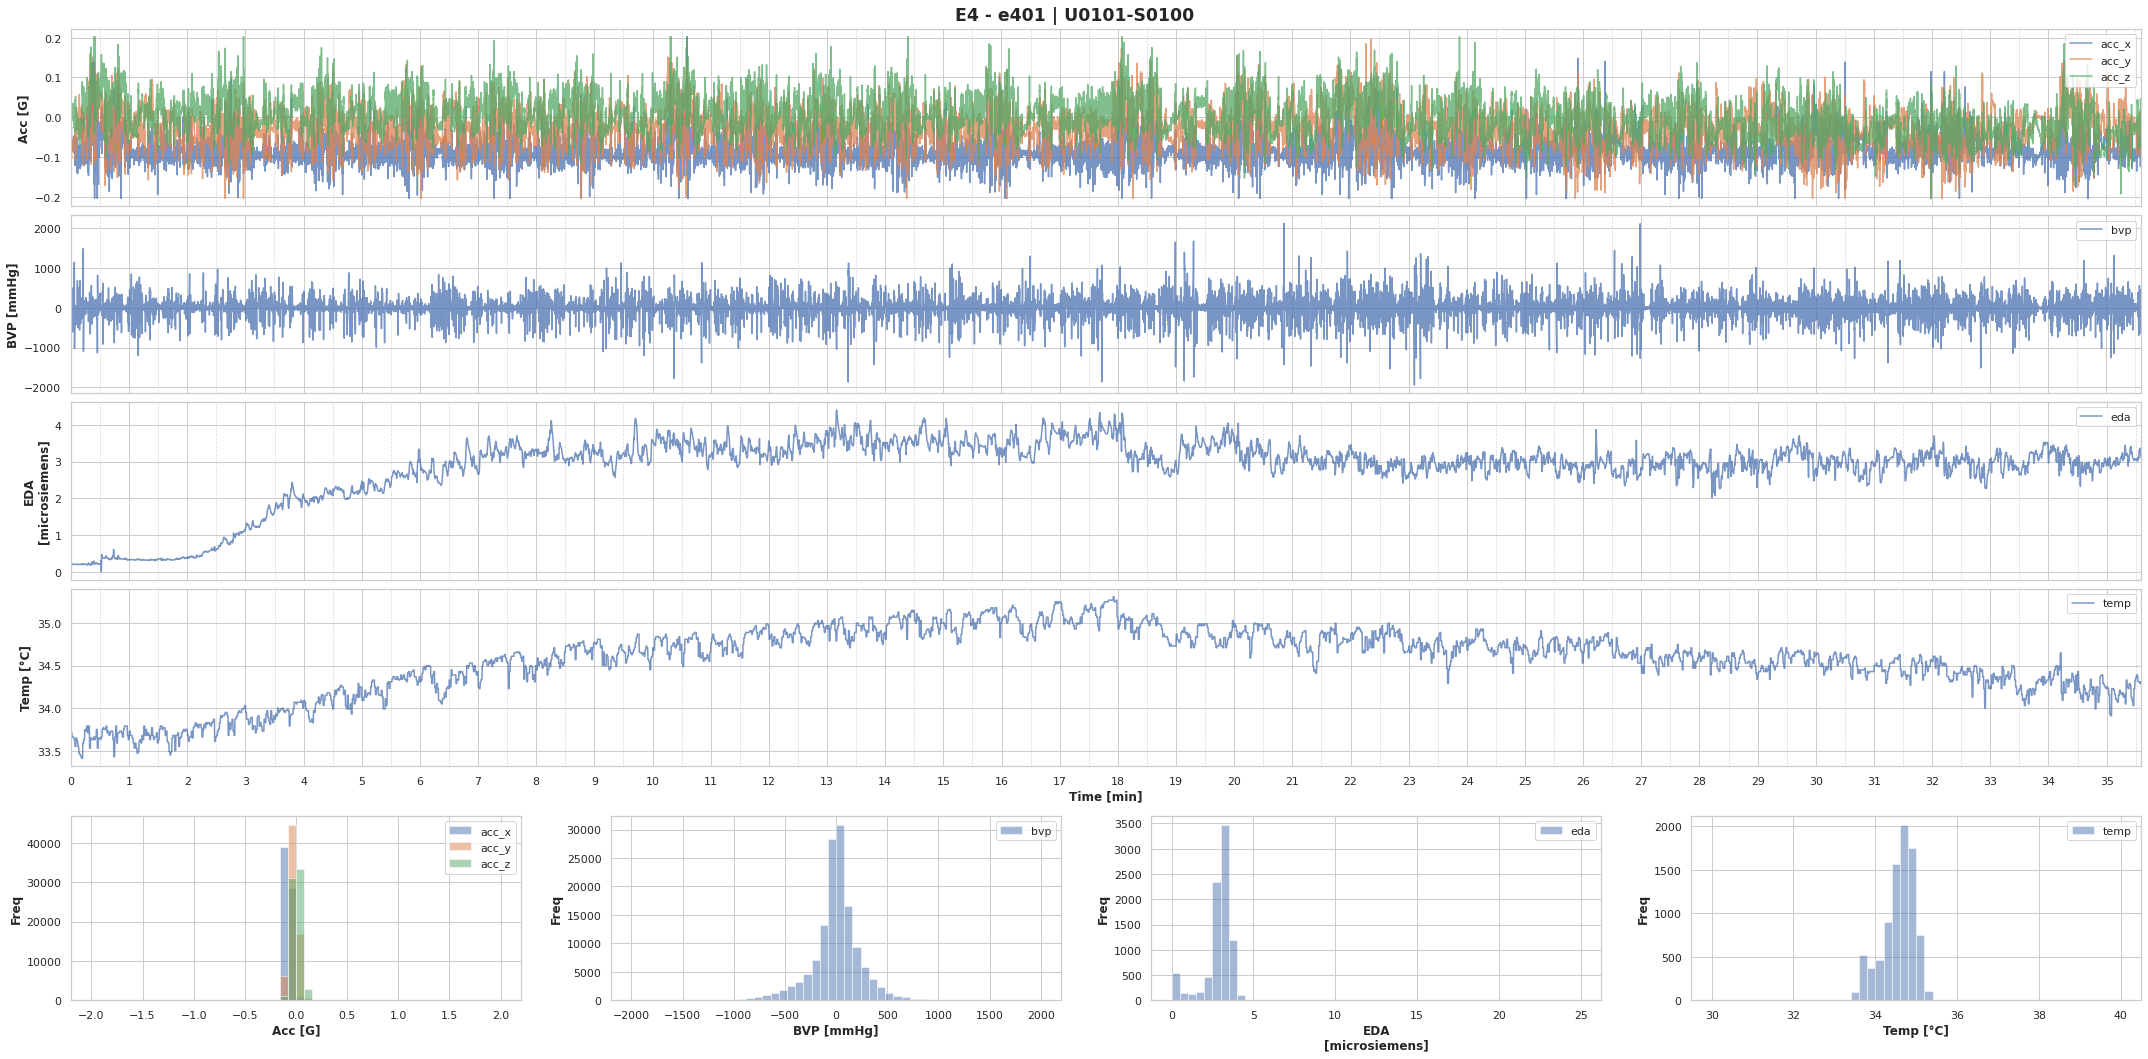

In [52]:
data = {
    "acc": df_e4_acc,
    "bvp": df_e4_bvp,
    "eda": df_e4_eda,
    "temp": df_e4_temp,    
}

fig = plot_e4_all(data, cfg.user.name, cfg.session, cfg.device)
fig.show()

## Next Step

Next step might be building your models to predict work activities!
OpenPack team prepare some tutorial to build models using PyTorch.
Please visit [GitHub: opnepack-torch](https://github.com/open-pack/openpack-torch)!
I hope you will enjoy this competition!